In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import seaborn as sns

C:\Users\Burning\AppData\Local\Temp\ipykernel_25016\1965621732.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd.DataFrame(x1).append(pd.DataFrame(x2), ignore_index=True)


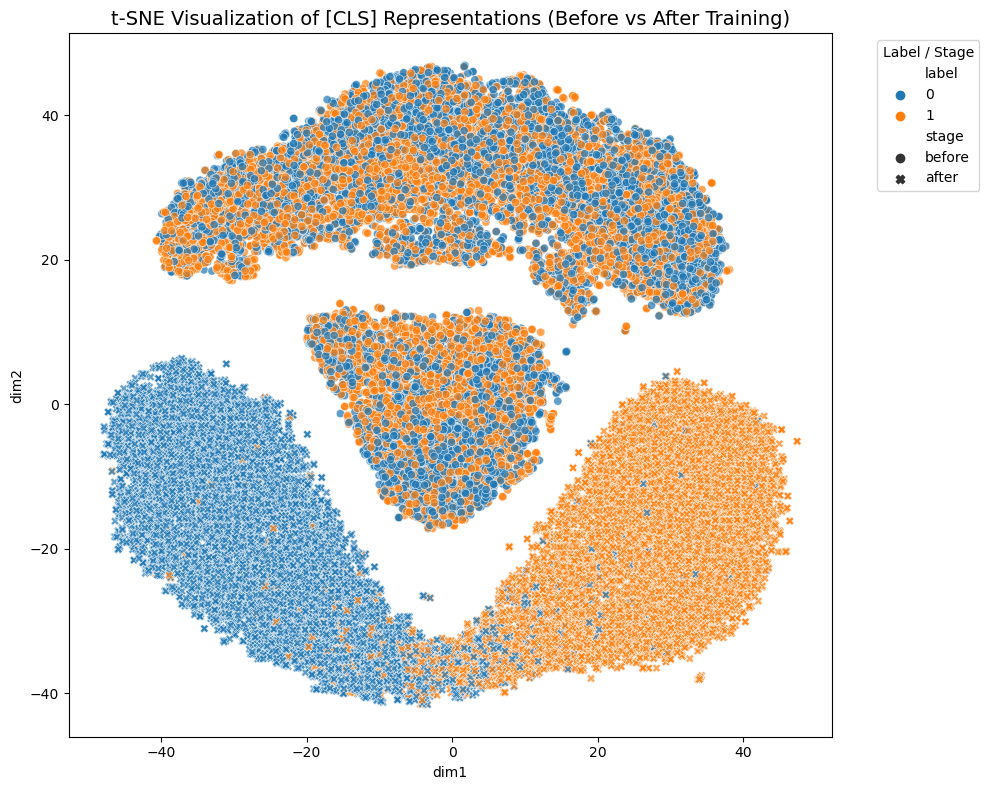

In [3]:


def load_and_prepare(path, label='pretrain'):
    df = pd.read_csv(path)
    features = df.drop(columns=['label']).values
    labels = df['label'].values
    return features, labels, [label] * len(labels)

x1, y1, stage1 = load_and_prepare('C:\\Users\\Burning\\Desktop\\temp\\cls_hidden1.csv', label='before')
x2, y2, stage2 = load_and_prepare('C:\\Users\\Burning\\Desktop\\temp\\cls_hidden2.csv', label='after')

X = pd.DataFrame(
    data = StandardScaler().fit_transform(
        pd.DataFrame(x1).append(pd.DataFrame(x2), ignore_index=True)
    )
)
Y = pd.Series(list(y1) + list(y2), name='label')
Stage = pd.Series(stage1 + stage2, name='stage')

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X)

df_vis = pd.DataFrame(X_embedded, columns=['dim1', 'dim2'])
df_vis['label'] = Y
df_vis['stage'] = Stage

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis, 
    x='dim1', y='dim2', 
    hue='label', 
    style='stage',
    palette='tab10',
    alpha=0.7
)
plt.title('t-SNE Visualization of [CLS] Representations (Before vs After Training)', fontsize=14)
plt.legend(title='Label / Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('tsne_cls_comparison.png', dpi=300)
plt.show()


In [1]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        # [bsz, n_views, num_hiddens]
        features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [3]:
x1 = torch.ones([16, 10])
x2 = torch.ones([16, 10])
x3 = torch.ones([16, 10])
y = torch.ones([16, 1])
features = torch.stack([x1, x2, x3], dim=1)
loss = SupConLoss()
print(loss(features, y))

tensor(3.8501)
